# Book Genre Prediction

## 0.1 Import necessary packages

In [1]:
import pandas as pd
import numpy as np
import re
import spacy
from spellchecker import SpellChecker
from langdetect import detect
from collections import Counter 

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns 

import en_core_web_sm
nlp = spacy.load('en_core_web_sm')
spell = SpellChecker()

## 0.2 Import dataset

Credit: https://drive.google.com/drive/folders/1tLFy-hqeFu6Ld6Z-IZ13NQazT1xfos41 (NUS IT1244 AY2425 SEM1 Course Project Dataset)

* This data consists of two columns. - Summary - Genre 
* Summary is the book synopsis
* Since there are 10 classes, this is a **Multiclass Classification** problem
* Genre have number 1 to 10, which represents the class of the respective synopsis. The class information is shown below

'fantasy': 1,
'science': 2,
'crime': 3,
'history': 4,
'horror': 5,
'thriller': 6,
'psychology': 7,
'romance': 8,
'sports': 9,
'travel': 10

In [2]:
df = pd.read_csv('data.csv')

## 1.0 Data Exploration and Analysis

There are a total of 4657 observations in this dataset, with 2 columns `summary` and `genre` which represents the book synopsis and the different genres (labelled as 1 to 10) respectively.

In [3]:
print(df.shape)

(4657, 2)


## 1.1 Remove nonsensical entries and filter English-only summaries

Upon taking a closer look at the dataset, several problematic text entries were identified in the dataset. These include corrupted and non-english summaries as well as improperly encoded summaries (with symbols like `==`). Such entries are unlikely to provide meaningful information and may introduce noise duing downstream modelling.

Therefore, these entries were removed during preprocessing to improve data qiality and ensure suitability of dataset.

In [4]:
print(f'1. {df['summary'][262]}') # corrupted entries
print(f'2. {df['summary'][4045][:100]}...') # non-english entries (only first 100 characters is printed)
print(f'3. {df['summary'][2410]}') # improperly encoded summaries

1. - --&#62; &#60;!-
2. -Feliz 53 cumpleaños, doctor. Bienvenido al primer día de su muerte. Pertenezco a algún momento de s...
3.  ==Character


In [5]:
def preprocess_words(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    if text.strip() == '':
        return ''
    if detect(text) != 'en':
        return ''
    doc = nlp(text)

    filtered_tokens = []
    for token in doc:
        if token.is_punct or token.is_stop or len(token.text) < 2 or token.text not in spell: 
            # filter stop words, punctuation mark, words with less than 2 char and wrongly spelled words
            continue
        filtered_tokens.append(token.lemma_) # append base form, lowercase of the word
    return ' '.join(filtered_tokens) # return a list

In [6]:
print('Before preprocessing')
print("=" * 30)
print(f'1. {df['summary'][262]}') # corrupted entries
print(f'2. {df['summary'][4045][:100]}...') # non-english entries (only first 100 characters is printed)
print(f'3. {df['summary'][2410]}') # improperly encoded summaries

print('\nAfter preprocessing')
print("=" * 30)
print(f'1. {preprocess_words(df['summary'][262])}') # corrupted entries
print(f'2. {preprocess_words(df['summary'][4045])}') # non-english entries 
print(f'3. {preprocess_words(df['summary'][2410])}') # improperly encoded summaries

Before preprocessing
1. - --&#62; &#60;!-
2. -Feliz 53 cumpleaños, doctor. Bienvenido al primer día de su muerte. Pertenezco a algún momento de s...
3.  ==Character

After preprocessing
1. 
2. 
3. Character


In [7]:
df['cleaned_summary'] = df['summary'].apply(lambda x: preprocess_words(x))
df = df[df['cleaned_summary'] != ''] # filter out empty entries in cleaned_summary resulted from preprocess_words()

## 1.2 Removing outliers

While all genres have similar median word count, class 3, 4, and 5 tend to have extreme outliers, which are removed to reduce the influence of extreme values on downstream modelling. The first 5 genres have a larger variance compared to the last 5 genres, which may reflect differences in genre-specific writing styles.

In [8]:
# create word_count column based on cleaned_summary 
df['word_count'] = df['cleaned_summary'].apply(lambda x: len(x.split(" ")))

In [9]:
# remove outliers withn each genre
def remove_outliers_by_genre(dataframe, low = 0.01, high = 0.99):
    new_df = pd.DataFrame()
    for i in range(1, 11):
        temp = dataframe[dataframe['genre'] == i].copy() # filter by genre
        low_threshold = temp['word_count'].quantile(low)
        high_threshold = temp['word_count'].quantile(high)

        res = temp[(temp['word_count'] >= low_threshold) &
                        (temp['word_count'] <= high_threshold)]
        
        new_df = pd.concat([new_df, res])
    return new_df

og_df = df.copy()
df = remove_outliers_by_genre(df)

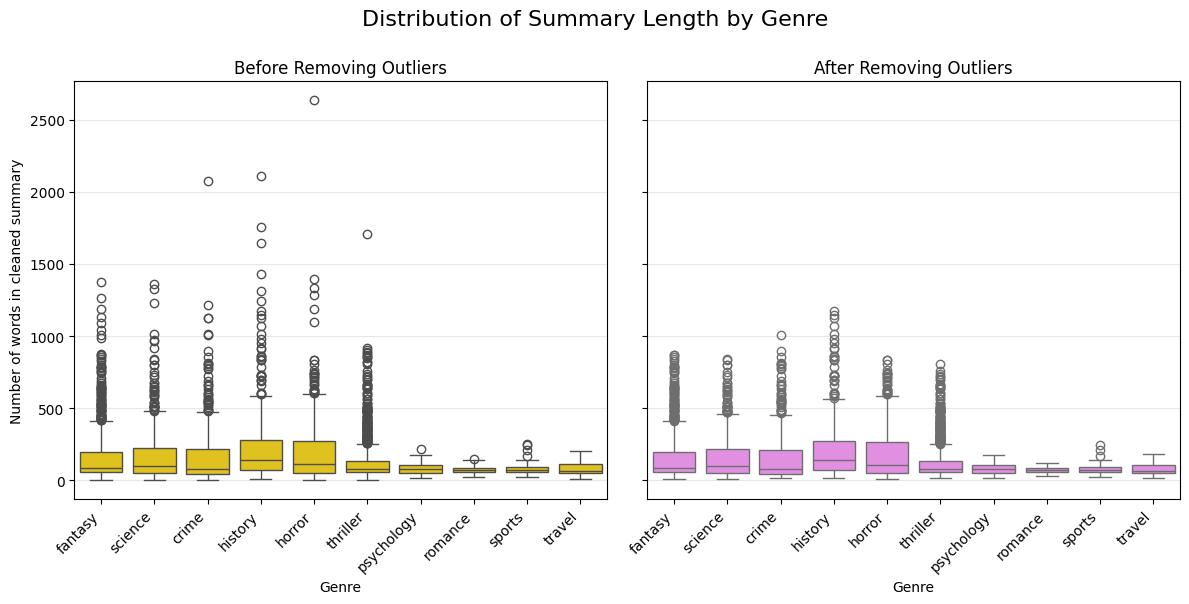

In [10]:
fig, ax = plt.subplots(1, 2, sharey = True, figsize = (12, 6))

sns.boxplot(x = 'genre', y = 'word_count', data = og_df, color = 'gold', ax = ax[0])
ax[0].set_xticks(range(0, 10))
ax[0].set_xticklabels(['fantasy', 'science', 'crime', 'history', 'horror', 
                         'thriller', 'psychology', 'romance', 'sports', 'travel'], 
                        rotation = 45, ha = 'right')
ax[0].set_xlabel('Genre')
ax[0].set_ylabel('Number of words in cleaned summary')
ax[0].set_title('Before Removing Outliers')
ax[0].grid(alpha = 0.3, axis = 'y')

sns.boxplot(x = 'genre', y = 'word_count', data = df, color = 'violet', ax = ax[1])
ax[1].set_xticks(range(0, 10))
ax[1].set_xticklabels(['fantasy', 'science', 'crime', 'history', 'horror', 
                         'thriller', 'psychology', 'romance', 'sports', 'travel'], 
                        rotation = 45, ha = 'right')
ax[1].set_xlabel('Genre')
ax[1].set_title('After Removing Outliers')
ax[1].grid(alpha = 0.3, axis = 'y')

fig.suptitle('Distribution of Summary Length by Genre', fontsize = 16, y = 1)
plt.tight_layout()
plt.show()

## 1.3 Train-Test Split

The dataset also exibits an 10x class imbalance. After removing the outliers, there is a total of 4541 observations, with the largest class (class 6) containing 992 observations, while class 7, 8, 9 and 10 contain around 100 observations each. This imbalance suggests that class distribution and weight must be carefully considered during train-test set splitting and model training.

In [11]:
print(df.shape)
print(df['genre'].value_counts().sort_index())

(4541, 4)
genre
1     855
2     629
3     490
4     588
5     587
6     992
7      96
8     107
9      99
10     98
Name: count, dtype: int64


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_summary'],
    df['genre'],
    test_size = 0.2,
    random_state = 2026,
    stratify = df['genre']) # using stratified split to conserve the class ratio in original dataset

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 3632 samples
Test set: 909 samples


In [13]:
# Training set data only
class_ids = list(range(1, 11))
train_samples = list(y_train.value_counts().sort_index())

# Calculate statistical thresholds
Q1 = np.percentile(train_samples, 25)  # Lower quartile (25th percentile)
Q3 = np.percentile(train_samples, 75)  # Upper quartile (75th percentile)
median_samples = np.median(train_samples)
mean_samples = np.array(train_samples).mean()
min_samples = np.array(train_samples).min()
max_samples = np.array(train_samples).max()

print("Statistical Thresholds Calculation:")
print("=" * 40)
print(f"Lower quartile (Q1): {Q1:.1f} samples")
print(f"Upper quartile (Q3): {Q3:.1f} samples")
print(f"Median: {median_samples:.1f} samples")
print(f"Mean: {mean_samples:.1f} samples")
print(f"Range: {min_samples} - {max_samples} samples")

print("\nClass Distribution in Training Set & Class Count by Quartile:")
print("=" * 60)
for class_id, count in enumerate(train_samples):
    if count < Q1:
        status = "LOW"
    elif count > Q3:
        status = "HIGH"
    else:
        status = "MEDIUM"
    print(f"Class {class_id + 1:2d}: {count:3d} samples - {status}")

Statistical Thresholds Calculation:
Lower quartile (Q1): 80.8 samples
Upper quartile (Q3): 494.8 samples
Median: 431.0 samples
Mean: 363.2 samples
Range: 77 - 793 samples

Class Distribution in Training Set & Class Count by Quartile:
Class  1: 684 samples - HIGH
Class  2: 503 samples - HIGH
Class  3: 392 samples - MEDIUM
Class  4: 470 samples - MEDIUM
Class  5: 470 samples - MEDIUM
Class  6: 793 samples - HIGH
Class  7:  77 samples - LOW
Class  8:  86 samples - MEDIUM
Class  9:  79 samples - LOW
Class 10:  78 samples - LOW


## 1.4 Feature Engineering: Vectorization using TF-IDF

The code below converts the text summaries into numerical features using **TF-IDF (Term Frequency-Inverse Document Frequency)**. This technique transforms text into vectors by weighing words based on:
- How frequently they appear in each document (TF)
- How rare they are across all documents (IDF)

This helps our model identify words that are truly distinctive for each genre, rather than just common words that appear everywhere.

**TF-IDF Configuration:**
- Extract top 5000 most important features (unigrams + bigrams)
- Filter out extremely rare words (appearing in <2 documents)
- Remove overly common words (appearing in >80% of documents)
- Include both single words and two-word phrases for better context
- Remove English stop words if not filtered out before

In [14]:
tfidf = TfidfVectorizer(
    max_features = 5000, # top 5000 unique vocab
    ngram_range = (1, 2),  # Unigrams and bigrams
    min_df = 2, # only consider vocal appear in 2 or more documents
    max_df = 0.8, # remove vocab that appears in >80% of the documents
    stop_words = 'english'
)

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

print(f"Vocabulary size: {len(tfidf.vocabulary_)}")
print(f"Training matrix shape: {X_train_vec.shape}")

Vocabulary size: 5000
Training matrix shape: (3632, 5000)


## 2.0 Testing Multiple Models based on Training Data only

Using 5-Fold Cross Validation method, Logistic Regression, Multinomial Naive Bayes (Multinomial NB) and Linear Support Vector Classification (Linear SVC) model's performances are compared to check which model is the most suitable for this text classification problem.

In [15]:
# Define Models
models = {
    'Logistic Regression': LogisticRegression(
        max_iter = 1000,
        class_weight = 'balanced', # handle class imbalance
        random_state = 2026
    ),
    'Multinomial NB': MultinomialNB(),
    'Linear SVC': LinearSVC(
        class_weight = 'balanced', # handle class imbalance
        max_iter = 1000,
        random_state = 2026
    )
}

## 2.1  5-Fold Stratified Cross Validation

From the table below, Logistic Regression model performs better than Multinomial NB model and Linear SVC model.

In [16]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 2026)

scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
    'precision_macro': make_scorer(
        precision_score, average='macro', zero_division=0
    ),
    'recall_macro': make_scorer(
        recall_score, average='macro', zero_division=0
    ),
    'f1_weighted': 'f1_weighted'
}

results = {}

print("5-Fold Stratified Cross-Validation Result:")
print("="*50)

for name, model in models.items():
    print(f"Model: {name}")
    
    cv_results = cross_validate(
        model,
        X_train_vec,
        y_train,
        cv = cv,
        scoring = scoring,
        return_train_score = False
    )
    
    results[name] = {
        'accuracy': cv_results['test_accuracy'].mean(),
        'accuracy_std': cv_results['test_accuracy'].std(),
        'precision': cv_results['test_precision_macro'].mean(),
        'precision_std': cv_results['test_precision_macro'].std(),
        'recall': cv_results['test_recall_macro'].mean(),
        'recall_std': cv_results['test_recall_macro'].std(),
        'f1_macro': cv_results['test_f1_macro'].mean(),
        'f1_macro_std': cv_results['test_f1_macro'].std(),
        'f1_weighted': cv_results['test_f1_weighted'].mean()
    }
    
    print(f"  Accuracy       : {results[name]['accuracy']:.4f} (+/- {results[name]['accuracy_std']:.4f})")
    print(f"  Macro Precision: {results[name]['precision']:.4f} (+/- {results[name]['precision_std']:.4f})")
    print(f"  Macro Recall   : {results[name]['recall']:.4f} (+/- {results[name]['recall_std']:.4f})")
    print(f"  F1 Macro       : {results[name]['f1_macro']:.4f} (+/- {results[name]['f1_macro_std']:.4f})")
    print(f"  F1 Weighted    : {results[name]['f1_weighted']:.4f}\n")

5-Fold Stratified Cross-Validation Result:
Model: Logistic Regression
  Accuracy       : 0.7004 (+/- 0.0210)
  Macro Precision: 0.6839 (+/- 0.0175)
  Macro Recall   : 0.7177 (+/- 0.0267)
  F1 Macro       : 0.6944 (+/- 0.0227)
  F1 Weighted    : 0.7009

Model: Multinomial NB
  Accuracy       : 0.5862 (+/- 0.0074)
  Macro Precision: 0.4450 (+/- 0.0031)
  Macro Recall   : 0.3513 (+/- 0.0050)
  F1 Macro       : 0.3486 (+/- 0.0064)
  F1 Weighted    : 0.5435

Model: Linear SVC
  Accuracy       : 0.6787 (+/- 0.0185)
  Macro Precision: 0.6691 (+/- 0.0148)
  Macro Recall   : 0.6623 (+/- 0.0285)
  F1 Macro       : 0.6635 (+/- 0.0222)
  F1 Weighted    : 0.6781



## 3.0 Try Gradient Boosted Model: XGBoost Classifier

In [17]:
# Since XGBoost expects labels to start from 0, encode class label as class n = class n-1 
le = LabelEncoder()

y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

## 3.1 Finding optimal learning rate for XGBoost Model

For learning rate from a range of 0.01 to 0.3, using accuracy as the basis of comparison, plot accuracy against learning rate to find the optimal learning rate that produces that highest accuracy. 

From the graph, optimal learning rate = 0.2

In [18]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 2026)

configs = [
    {'learning_rate': 0.01, 'n_estimators': 500},
    {'learning_rate': 0.05, 'n_estimators': 300},
    {'learning_rate': 0.1, 'n_estimators': 200},
    {'learning_rate': 0.2, 'n_estimators': 150},
    {'learning_rate': 0.3, 'n_estimators': 100},
]

xg_accuracy = []

for config in configs:
    xg_mdl = XGBClassifier(
        eval_metric='mlogloss',
        max_depth=4,
        learning_rate=config['learning_rate'],
        n_estimators=config['n_estimators'],
        random_state=2026,
        objective = 'multi:softmax',
        tree_method = 'hist'
    )

    sample_weights = compute_sample_weight('balanced', y_train)

    res = cross_validate(
        xg_mdl,
        X_train_vec,
        y_train_encoded,
        cv=cv,
        scoring={'accuracy': 'accuracy'}, # using accuracy as basis of comparison
        return_train_score=False,
        params={'sample_weight': sample_weights} 
    )

    xg_accuracy.append(res['test_accuracy'].mean())

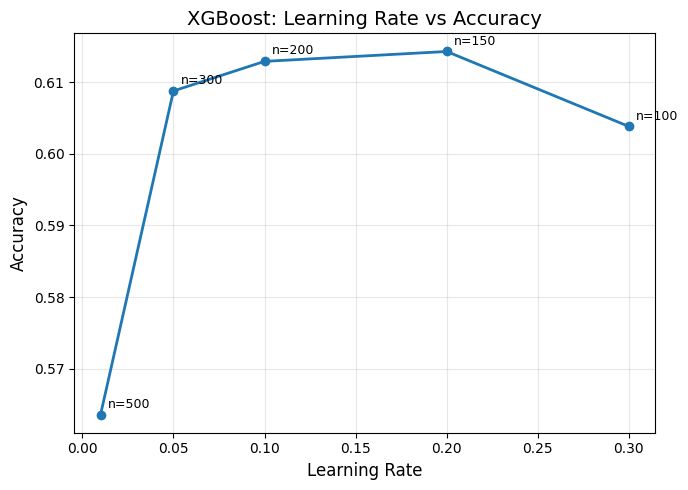

In [19]:
lr_values = [c['learning_rate'] for c in configs]

plt.figure(figsize = (7, 5))
plt.plot(lr_values, xg_accuracy, marker = 'o', linewidth = 2, markersize = 6)
for i, (lr, acc) in enumerate(zip(lr_values, xg_accuracy)):
    plt.annotate(f"n={configs[i]['n_estimators']}", 
                 xy = (lr, acc), 
                 xytext = (5, 5), 
                 textcoords = 'offset points',
                 fontsize = 9)
plt.xlabel('Learning Rate', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('XGBoost: Learning Rate vs Accuracy', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3.2 Train XGBoost Classifier Model using 5-Fold Cross Validation

In [20]:
# XGBoost model using learning rate = 0.2
xg_mdl = XGBClassifier(
    eval_metric = 'mlogloss',
    max_depth = 4,
    learning_rate = 0.2,
    n_estimators = 100,
    random_state = 2026,
    objective = 'multi:softmax',
    tree_method = 'hist'
)

scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
    'precision_macro': make_scorer(
        precision_score, average='macro', zero_division=0
    ),
    'recall_macro': make_scorer(
        recall_score, average='macro', zero_division=0
    ),
    'f1_weighted': 'f1_weighted'
}

print("5-Fold Stratified Cross-Validation Result (XGBoost):")
print("="*50)

sample_weights = compute_sample_weight('balanced', y_train)

xg_cv_result = cross_validate(
    xg_mdl,
    X_train_vec,
    y_train_encoded,  # Use encoded labels
    cv=cv,
    scoring=scoring,
    return_train_score=False,
    params={'sample_weight': sample_weights}
)

xg_result = {
    'accuracy': xg_cv_result['test_accuracy'].mean(),
    'accuracy_std': xg_cv_result['test_accuracy'].std(),
    'precision': xg_cv_result['test_precision_macro'].mean(),
    'precision_std': xg_cv_result['test_precision_macro'].std(),
    'recall': xg_cv_result['test_recall_macro'].mean(),
    'recall_std': xg_cv_result['test_recall_macro'].std(),
    'f1_macro': xg_cv_result['test_f1_macro'].mean(),
    'f1_macro_std': xg_cv_result['test_f1_macro'].std(),
    'f1_weighted': xg_cv_result['test_f1_weighted'].mean()
}

# Print results
print(f"  Accuracy       : {xg_result['accuracy']:.4f} (+/- {xg_result['accuracy_std']:.4f})")
print(f"  Macro Precision: {xg_result['precision']:.4f} (+/- {xg_result['precision_std']:.4f})")
print(f"  Macro Recall   : {xg_result['recall']:.4f} (+/- {xg_result['recall_std']:.4f})")
print(f"  F1 Macro       : {xg_result['f1_macro']:.4f} (+/- {xg_result['f1_macro_std']:.4f})")
print(f"  F1 Weighted    : {xg_result['f1_weighted']:.4f}\n")

5-Fold Stratified Cross-Validation Result (XGBoost):
  Accuracy       : 0.6099 (+/- 0.0162)
  Macro Precision: 0.5915 (+/- 0.0218)
  Macro Recall   : 0.5711 (+/- 0.0160)
  F1 Macro       : 0.5774 (+/- 0.0144)
  F1 Weighted    : 0.6090



## 4.0 Final Model

After trying multiple models (Logistic Regression, Naive Bayes, Linear SVC) and gradient boosting model (XGBoost), the overall performace of Logistic Regression outperforms the other models. Therefore, I will use Logistic Regression as my final model for this text classification problem.

In [21]:
final_model = LogisticRegression(
    max_iter = 1000,
    class_weight = 'balanced', # handle class imbalance
    random_state = 2026
)

sample_weights = compute_sample_weight('balanced', y_train)

final_model.fit(X_train_vec, y_train, sample_weight = sample_weights)
y_pred = final_model.predict(X_test_vec)

print('Classification Report (Test Set):')
print('='*55)
print(classification_report(y_test, y_pred))

print('\nTest Set Performance')
print('='*30)
print(f'Accuracy           : {(accuracy_score(y_test, y_pred) * 100):.2f}%')
print(f'Macro Precision    : {(precision_score(y_test, y_pred, average='macro', zero_division=0) * 100):.2f}%')
print(f'Weighted Precision : {(precision_score(y_test, y_pred, average='weighted', zero_division=0) * 100):.2f}%')
print(f'Macro Recall       : {(recall_score(y_test, y_pred, average='macro', zero_division=0) * 100):.2f}%')
print(f'Weighted Recall    : {(recall_score(y_test, y_pred, average='weighted', zero_division=0) * 100):.2f}%')
print(f'Macro F1           : {(f1_score(y_test, y_pred, average='macro') * 100):.2f}%')
print(f'Weighted F1        : {(f1_score(y_test, y_pred, average='weighted') * 100):.2f}%')

Classification Report (Test Set):
              precision    recall  f1-score   support

           1       0.79      0.68      0.73       171
           2       0.69      0.75      0.72       126
           3       0.66      0.78      0.71        98
           4       0.67      0.76      0.71       118
           5       0.62      0.63      0.63       117
           6       0.76      0.60      0.67       199
           7       0.59      0.68      0.63        19
           8       0.34      0.57      0.43        21
           9       0.75      0.90      0.82        20
          10       0.89      0.80      0.84        20

    accuracy                           0.69       909
   macro avg       0.68      0.72      0.69       909
weighted avg       0.71      0.69      0.69       909


Test Set Performance
Accuracy           : 69.31%
Macro Precision    : 67.69%
Weighted Precision : 70.61%
Macro Recall       : 71.62%
Weighted Recall    : 69.31%
Macro F1           : 69.01%
Weighted F1      

## 4.1 Plotting Confusion Matrix

From the confusion matrix, class 1 (Fantasy) and class 6 (Thriller) has the highest true positive rate, which could be due to them having the top 2 number of samples in the dataset. 

Additionally, it is also important to note that most of the class 6 (Thriller) that are predicted wrongly is predicted as class 3 (Crime), which could be due to both genres having similar key words in their synopsis.

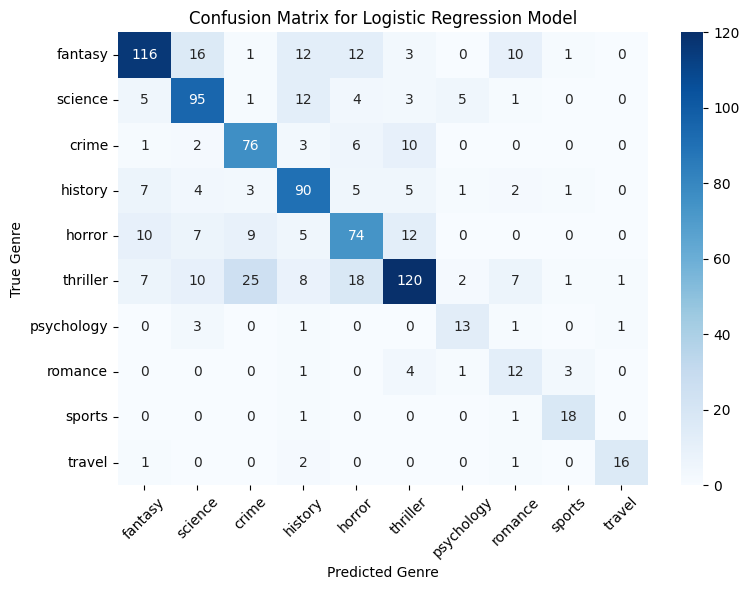

In [22]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', 
            xticklabels = ['fantasy', 'science', 'crime', 'history', 'horror', 'thriller', 'psychology', 'romance', 'sports', 'travel'],
            yticklabels = ['fantasy', 'science', 'crime', 'history', 'horror', 'thriller', 'psychology', 'romance', 'sports', 'travel'])
plt.title('Confusion Matrix for Logistic Regression Model')
plt.ylabel('True Genre')
plt.xlabel('Predicted Genre')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

## 4.2 Error Analysis

Based on the confusion matrix, it shows that some classes are often being misclassified as another class. One example is class 6 (Thriller) is often being predicted as class 3 (Crime). The code below will analyse which is the top 3 most confused pair of genres.

In [23]:
genre_list = ['fantasy', 'science', 'crime', 'history', 'horror', 'thriller', 'psychology', 'romance', 'sports', 'travel']

errors_df = pd.DataFrame({
    'true_genre': y_test.values,
    'predicted_genre': y_pred,
})
errors_df['correct?'] = errors_df['true_genre'] == errors_df['predicted_genre']

# Most Confused pair
misclassified = errors_df[errors_df['correct?'] == False]
confusion_pairs = Counter(zip(misclassified['true_genre'], misclassified['predicted_genre']))

print("Most Common Confusions (True → Predicted):")
k = 1
for (true, pred), count in confusion_pairs.most_common(3):
    print(f"{k}. Class {true} ({genre_list[true  - 1]}) → Class {pred} ({genre_list[pred - 1]}): {count} times")
    k += 1

Most Common Confusions (True → Predicted):
1. Class 6 (thriller) → Class 3 (crime): 25 times
2. Class 6 (thriller) → Class 5 (horror): 18 times
3. Class 1 (fantasy) → Class 2 (science): 16 times


## 4.3 Visualisation of Top 5 Unique Words for Genres that are often Confused

For the top 3 most confused pair of genres, the code below will visualise the top 5 unique word in each genre, possibly showing the reason why the model is classifying these classes wrongly.

In [24]:
confusing_classes = df[df['genre'].isin([1, 2, 3, 5, 6])]
genre_names = {
    1: 'Fantasy',
    2: 'Science', 
    3: 'Crime',
    4: 'History',
    5: 'Horror',
    6: 'Thriller'
}
res_4_3 = {}

for idx, genre_id in enumerate([1, 2, 3, 5, 6]):
    genre_data = confusing_classes[confusing_classes['genre'] == genre_id]
    
    tfidf = TfidfVectorizer(
        max_features=5, 
        ngram_range=(1, 2), 
        min_df=2, 
        max_df=0.8,
        stop_words='english'
    )
    tfidf_matrix = tfidf.fit_transform(genre_data['cleaned_summary'])
    
    feature_names = tfidf.get_feature_names_out()
    avg_tfidf = np.asarray(tfidf_matrix.mean(axis=0)).ravel()
    
    top_words = pd.DataFrame({
        'word': feature_names,
        'tfidf_score': avg_tfidf
    }).sort_values('tfidf_score', ascending=False)
    
    res_4_3[genre_id] = top_words

### 4.3.1 Class 6 (Thriller) vs Class 3 (Crime)

From the graph, both *kill* and *man* appear in class 6 and class 3 top 5 unique words, which suggests that the vocabulary used in the synopsis for both genres are quite similar, which could explain why class 6 often being wrongly classified as class 3 by our model.

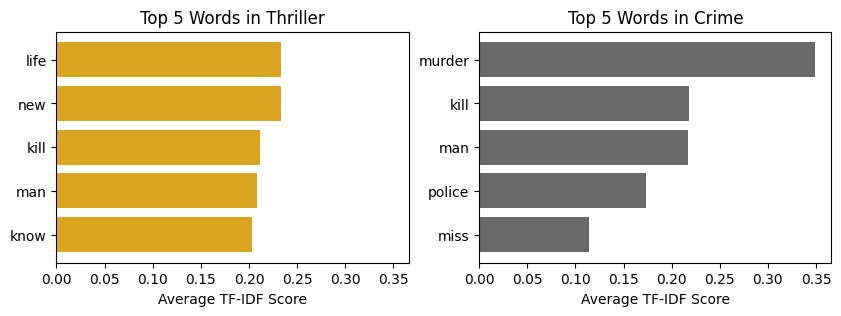

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharex = True)

axes[0].barh(res_4_3[6]['word'], res_4_3[6]['tfidf_score'], color = 'goldenrod')
axes[0].set_xlabel('Average TF-IDF Score')
axes[0].set_title(f'Top 5 Words in {genre_names[6]}')
axes[0].invert_yaxis()

axes[1].barh(res_4_3[3]['word'], res_4_3[3]['tfidf_score'], color = 'dimgray')
axes[1].set_xlabel('Average TF-IDF Score')
axes[1].set_title(f'Top 5 Words in {genre_names[3]}')
axes[1].invert_yaxis()

### 4.3.2 Class 6 (Thriller) vs Class 5 (Horror)

Similar to the above, both *kill* and *man* appear in class 6 and class 5 top 5 unique words, which shows that the vocabulary used in the synopsis for both genres are quite similar, resulting in more class 6 being wrongly classified as class 5.

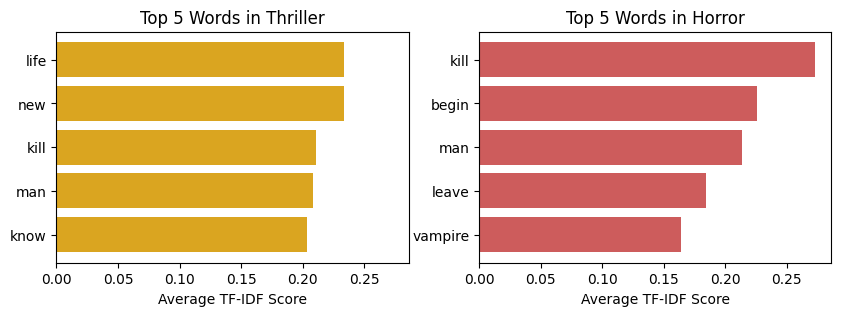

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharex = True)

axes[0].barh(res_4_3[6]['word'], res_4_3[6]['tfidf_score'], color = 'goldenrod')
axes[0].set_xlabel('Average TF-IDF Score')
axes[0].set_title(f'Top 5 Words in {genre_names[6]}')
axes[0].invert_yaxis()

axes[1].barh(res_4_3[5]['word'], res_4_3[5]['tfidf_score'], color = 'indianred')
axes[1].set_xlabel('Average TF-IDF Score')
axes[1].set_title(f'Top 5 Words in {genre_names[5]}')
axes[1].invert_yaxis()

### 4.3.3 Class 1 (Fantasy) vs Class 2 (Science)

Both *world* and *time* appear in class 1 and class 2 top 3 unique words, which shows that the vocabulary used in the synopsis for both genres are quite similar, resulting in more class 1 being wrongly classified as class 2.

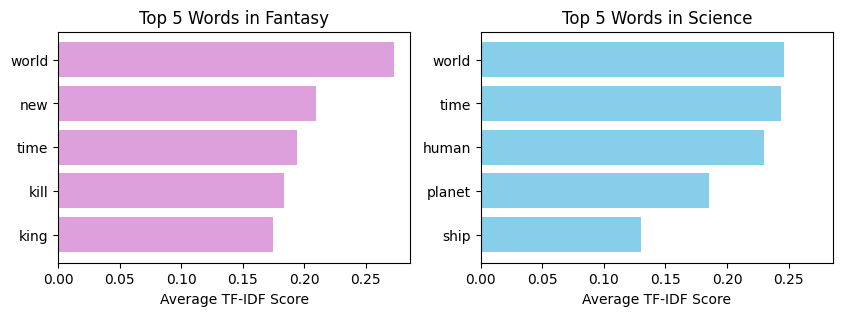

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharex = True)

axes[0].barh(res_4_3[1]['word'], res_4_3[1]['tfidf_score'], color = 'plum')
axes[0].set_xlabel('Average TF-IDF Score')
axes[0].set_title(f'Top 5 Words in {genre_names[1]}')
axes[0].invert_yaxis()

axes[1].barh(res_4_3[2]['word'], res_4_3[2]['tfidf_score'], color = 'skyblue')
axes[1].set_xlabel('Average TF-IDF Score')
axes[1].set_title(f'Top 5 Words in {genre_names[2]}')
axes[1].invert_yaxis()

## Reference

https://medium.com/data-science/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613

https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

https://github.com/codebasics/nlp-tutorials/blob/main/16_word_vectors_gensim_text_classification/gensim_w2v_google.ipynb

https://xgboost.readthedocs.io/en/latest/python/python_api.html
